In [80]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from datetime import datetime
from test import transform_data, test_rf, test_rf_hp, find_threshold, test_xgb, test_lightgbm, test_logistic_regression, test_perceptron

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# N = 24000000
# df = pl.read_parquet('ibm_fraud_processed.pq', n_rows=N)
df = pl.scan_parquet('ibm_fraud_processed.pq')
df = df.filter((pl.col('date') > datetime(2019,1,1)) & (pl.col('date') < datetime(2020,1,1))).collect() 
print(df.columns)
N = df.height
print(N)

['timestamp', 'customer.id', 'direction', 'amount_usd', 'amount_signed', 'date', 'customer.name', 'customer.age', 'customer.gender', 'customer.address', 'customer.city', 'customer.state', 'customer.zip', 'score', 'total_debt', 'credit_limit', 'latitude', 'longitude', 'card.id', 'card.number', 'card.mcc', 'card.brand', 'card.type', 'card.chip', 'card.expiry_date', 'card.cvv', 'num_cards', 'merchant.name', 'merchant.city', 'merchant.state', 'error', 'is_fraud', 'is_known_merchant', 'seen_count_last_2_days', 'seen_count_mcc_last_2_days', 'seen_count_last_7_days', 'seen_count_mcc_last_7_days', 'seen_count_last_30_days', 'seen_count_mcc_last_30_days', 'log_timediff', 'same_city', 'same_state']
1723938


In [3]:
print(df.select(pl.col("card.brand").unique()))
print(df.select(pl.col("card.type").unique()))
print(df.select(pl.col("card.chip").unique()))
print(df.select(pl.col("error").unique()))
print(df.select(pl.col("is_fraud").unique()))
print(df.select(pl.col("card.mcc").unique()))

shape: (4, 1)
┌────────────┐
│ card.brand │
│ ---        │
│ str        │
╞════════════╡
│ Mastercard │
│ Visa       │
│ Amex       │
│ Discover   │
└────────────┘
shape: (3, 1)
┌─────────────────┐
│ card.type       │
│ ---             │
│ str             │
╞═════════════════╡
│ Debit           │
│ Debit (Prepaid) │
│ Credit          │
└─────────────────┘
shape: (3, 1)
┌────────────────────┐
│ card.chip          │
│ ---                │
│ str                │
╞════════════════════╡
│ Online Transaction │
│ Chip Transaction   │
│ Swipe Transaction  │
└────────────────────┘
shape: (22, 1)
┌─────────────────────────────────┐
│ error                           │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ Technical Glitch                │
│ Bad CVV,Insufficient Balance    │
│ Bad PIN,Technical Glitch        │
│ Bad Card Number,Insufficient B… │
│ Bad Card Number                 │
│ …                               │
│ Bad Expi

In [4]:
fraud_num = (df.filter(pl.col("is_fraud") == "Yes")).height
print("Number of fraudulent transactions among " + str(N) + " transactions: " + str(fraud_num))
print("Fraud ratio amongst the first " + str(N) + " transactions: " + str(float(fraud_num/N) * 100) + "%")

Number of fraudulent transactions among 1723938 transactions: 2087
Fraud ratio amongst the first 1723938 transactions: 0.12106003812202062%


Create a histogram of the amount_usd


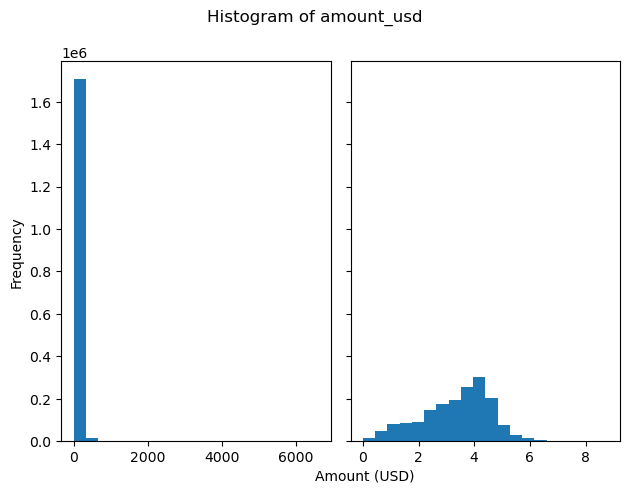

In [5]:
print("Create a histogram of the amount_usd")
n_bins = 20
amount_v = (df.select(pl.col("amount_usd"))).to_numpy().flatten()
# amount_debt = (df.select(pl.col("total_debt"))).to_numpy().flatten()
amount_vlog = np.log(amount_v + 1)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(amount_v, bins=n_bins)
axs[1].hist(amount_vlog, bins=n_bins)
fig.suptitle('Histogram of amount_usd')
fig.text(0.5, 0, 'Amount (USD)')
axs[0].set_ylabel('Frequency')
plt.show()


A closer look at transformed data


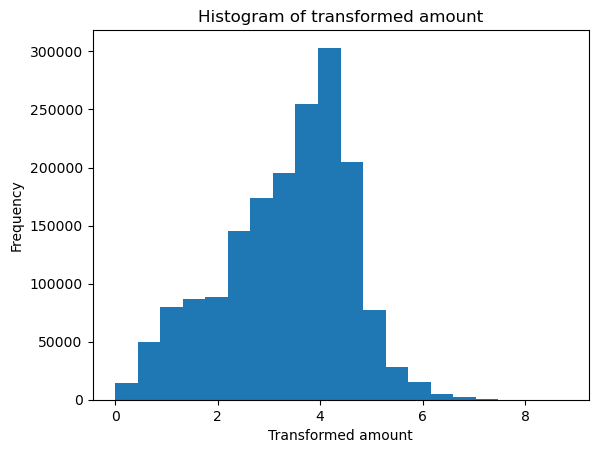

In [6]:
print("A closer look at transformed data")
#plt.clf()
fig, axs = plt.subplots()
axs.hist(amount_vlog, bins=n_bins)
axs.set_title('Histogram of transformed amount')
axs.set_ylabel('Frequency')
axs.set_xlabel('Transformed amount')
plt.show()

In [7]:
y = df.select(pl.when(pl.col("is_fraud") == "Yes").then(1).otherwise(0)).to_numpy()
print(y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


For starters, I've decided to select the following features: amount_usd (log), 'seen_count_last_2_days', 'seen_count_mcc_last_2_days', log_timediff, direction (removed null, binary enc),  date(extract day of weekend), same_city and same_state (binary), card.mcc(frequency enc), card.type (one-hot), card.chip(one-hot), error(frequency enc), is_known_merchant, customer.age (age buckets and label enc), relative_spend = amount_usd / credit_limit

In [8]:
df_trans = transform_data(df)
print("Data have been transformed")

Data have been transformed


In [10]:
df_trans.head()
#print(df_trans.columns)
# df_trans.select('is_fraud')

timestamp,customer.id,direction,amount_usd,amount_signed,date,customer.name,customer.age,customer.gender,customer.address,customer.city,customer.state,customer.zip,score,total_debt,credit_limit,latitude,longitude,card.id,card.number,card.mcc,card.brand_Amex,card.brand_Discover,card.brand_Mastercard,card.brand_Visa,card.type_Credit,card.type_Debit,card.type_Debit (Prepaid),card.chip_Chip Transaction,card.chip_Online Transaction,card.chip_Swipe Transaction,card.expiry_date,card.cvv,num_cards,merchant.name,merchant.city,merchant.state,error,is_fraud,is_known_merchant,seen_count_last_2_days,seen_count_mcc_last_2_days,seen_count_last_7_days,seen_count_mcc_last_7_days,seen_count_last_30_days,seen_count_mcc_last_30_days,log_timediff,same_city,same_state,amount_usd_log,relative_spend,weekday,age_bucket,direction_bin,error_frequency,mcc_frequency
i64,i64,str,f32,f32,datetime[ns],str,i64,str,str,str,str,f64,i64,f32,f32,f64,f64,i64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,str,i64,i64,i64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,f64,i8,i8,f32,f32,i8,i32,i32,u32,u32
1546668120,0,"""outbound""",120.300003,120.300003,2019-01-05 06:02:00,"""Hazel Robinson""",53,"""Female""","""462 Rose Lane""","""La Verne""","""CA""",1541.0,787,127613.0,24295.0,34.15,-117.76,0,4344676511950444,5411,0,0,0,1,0,1,0,1,0,0,"""12/2022""",623,5,7522433618679272954,"""Princeton""","""MA""","""Insufficient Balance""","""No""",0,0,0,0,0,0,4,11.016019,0,0,4.798267,0.004952,6,4,1,16826,205684
1546805400,0,"""outbound""",68.43,68.43,2019-01-06 20:10:00,"""Hazel Robinson""",53,"""Female""","""462 Rose Lane""","""La Verne""","""CA""",1536.0,787,127613.0,24295.0,34.15,-117.76,0,4344676511950444,5812,0,0,0,1,0,1,0,1,0,0,"""12/2022""",623,5,-2744911404133435018,"""North Grafton""","""MA""","""No error""","""No""",1,0,0,0,0,0,0,10.837245,0,0,4.24032,0.002817,7,4,1,1695271,127675
1547029080,0,"""outbound""",59.169998,59.169998,2019-01-09 10:18:00,"""Hazel Robinson""",53,"""Female""","""462 Rose Lane""","""La Verne""","""CA""",1536.0,787,127613.0,24295.0,34.15,-117.76,0,4344676511950444,7538,0,0,0,1,0,1,0,1,0,0,"""12/2022""",623,5,-4693979874497918566,"""North Grafton""","""MA""","""No error""","""No""",0,0,0,0,0,0,1,10.837245,0,0,4.097174,0.002435,3,4,1,1695271,64470
1547212380,0,"""outbound""",16.07,16.07,2019-01-11 13:13:00,"""Hazel Robinson""",53,"""Female""","""462 Rose Lane""","""La Verne""","""CA""",1541.0,787,127613.0,24295.0,34.15,-117.76,0,4344676511950444,5411,0,0,0,1,0,1,0,1,0,0,"""12/2022""",623,5,7522433618679272954,"""Princeton""","""MA""","""No error""","""No""",1,0,0,1,1,1,3,9.259226,0,0,2.837323,0.000661,5,4,1,1695271,205684
1547272440,0,"""outbound""",132.820007,132.820007,2019-01-12 05:54:00,"""Hazel Robinson""",53,"""Female""","""462 Rose Lane""","""La Verne""","""CA""",1566.0,787,127613.0,24295.0,34.15,-117.76,0,4344676511950444,5300,0,0,0,1,0,1,0,1,0,0,"""12/2022""",623,5,1913477460590765860,"""Sturbridge""","""MA""","""No error""","""No""",1,0,0,0,0,0,0,11.003116,0,0,4.896496,0.005467,6,4,1,1695271,78157


In [53]:
feature_columns1 = ['direction_bin', 'amount_usd_log', 'relative_spend', 'weekday', 'seen_count_last_2_days', 'same_state',                              'same_city', 'error_frequency', 'mcc_frequency','card.brand_Amex', 'card.brand_Discover', 'card.brand_Mastercard',
                   'card.brand_Visa', 'card.type_Credit', 'card.type_Debit', 'card.type_Debit (Prepaid)',                 'card.chip_Chip Transaction', 'card.chip_Online Transaction', 'card.chip_Swipe Transaction', 'is_known_merchant', 'age_bucket', 'log_timediff', 'seen_count_mcc_last_2_days'] 

feature_columns2 = ['direction_bin', 'amount_usd_log', 'relative_spend', 'weekday', 'seen_count_last_2_days', 'same_state',                              'same_city', 'error_frequency', 'mcc_frequency', 'card.type_Credit', 'card.type_Debit', 'card.type_Debit (Prepaid)',                 'card.chip_Chip Transaction', 'card.chip_Online Transaction', 'card.chip_Swipe Transaction', 'is_known_merchant'] 

target_column = 'is_fraud'
X1 = df_trans.select(feature_columns1).to_numpy()
X = df_trans.select(feature_columns2).to_numpy()
y = df_trans.select(pl.when(pl.col("is_fraud") == "Yes").then(1).otherwise(0)).to_numpy().flatten()

In [54]:
test_rf(X1, y, None)
best_threshold = find_threshold(X, y)
test_rf(X, y, best_threshold)


Without threshold optimization
[[344114      4]
 [   383     26]]
Precision: 0.8667
Recall: 0.0636
F1 Score: 0.1185
Best Threshold: 0.22, Best F1 Score: 0.3632
Without threshold optimization
[[344086     32]
 [   346     63]]
Precision: 0.6632
Recall: 0.1540
F1 Score: 0.2500
With threshold optimization
[[343878    240]
 [   265    144]]
Precision: 0.3750
Recall: 0.3521
F1 Score: 0.3632


In [77]:
test_xgb(X1, y, False)
test_xgb(X1, y, True)

XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    344118
           1       0.74      0.25      0.37       409

    accuracy                           1.00    344527
   macro avg       0.87      0.62      0.69    344527
weighted avg       1.00      1.00      1.00    344527

[[344083     35]
 [   308    101]]
XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    344118
           1       0.29      0.66      0.40       409

    accuracy                           1.00    344527
   macro avg       0.65      0.83      0.70    344527
weighted avg       1.00      1.00      1.00    344527

[[343461    657]
 [   139    270]]


In [69]:
test_lightgbm(X, y)

{0: 0.5006084581126538, 1: 411.37462686567164}
[LightGBM] [Info] Number of positive: 1675, number of negative: 1376430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 1378105, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001215 -> initscore=-6.711435
[LightGBM] [Info] Start training from score -6.711435
LightGBM Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    344118
           1       0.29      0.23      0.26       409

    accuracy                           1.00    344527
   macro avg       0.65      0.62      0.63    344527
weighted avg       1.00      1.00      1.00    344527

[[343886    232]
 [   313     96]]


In [ ]:
test_logistic_regression(X, y)

In [83]:
test_perceptron(X1,y)

Perceptron Results:
[[302841  41277]
 [   263    146]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    344118
           1       0.00      0.36      0.01       409

    accuracy                           0.88    344527
   macro avg       0.50      0.62      0.47    344527
weighted avg       1.00      0.88      0.93    344527

